In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import StackingClassifier
from scipy.stats import mode
from tqdm import tqdm 
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import RidgeClassifier



In [ ]:
file_path = 'Dataset.xlsx'  
dataset = pd.read_excel(file_path)

In [31]:
cols_to_drop = dataset.filter(like='Medication_').columns
dataset = dataset.drop(columns=cols_to_drop)

In [ ]:
# Filter the dataset for only 0 and 2 outcomes
dataset = dataset[dataset['Outcome_numerical'].isin([0, 2])]
# Update cluster_counts for the filtered dataset
cluster_counts = dataset['Outcome_numerical'].value_counts()
dataset['Outcome_numerical'] = dataset['Outcome_numerical'].replace(2, 1)
# Define the features (X) and the target (y) based on the filtered dataset
X = dataset.drop(columns=['Outcome_numerical'])
y = dataset['Outcome_numerical']

# Split the filtered data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=42)  # 70% training and 30% testing

# Standardize features for the filtered datasets
#scaler = StandardScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirm the sizes of the datasets after filtering and splitting
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)




(108, 110) (89, 110) (108,) (89,)


In [33]:
cluster_counts = dataset['Outcome_numerical'].value_counts()
cluster_counts


0    142
1     55
Name: Outcome_numerical, dtype: int64

# SMOTE model check

Original class distribution: Counter({0: 74, 1: 34})
SMOTE class distribution: Counter({0: 74, 1: 74})


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.719101   0.762693  0.719101  0.733933
Random Forest        0.752809   0.752809  0.752809  0.752809
Gradient Boosting    0.696629   0.721392  0.696629  0.706976
SVM                  0.719101   0.762693  0.719101  0.733933
XGB                  0.640449   0.673755  0.640449  0.654624
Bagging Classifier   0.730337   0.739293  0.730337  0.734453
Decision Tree        0.606742   0.658617  0.606742  0.627506


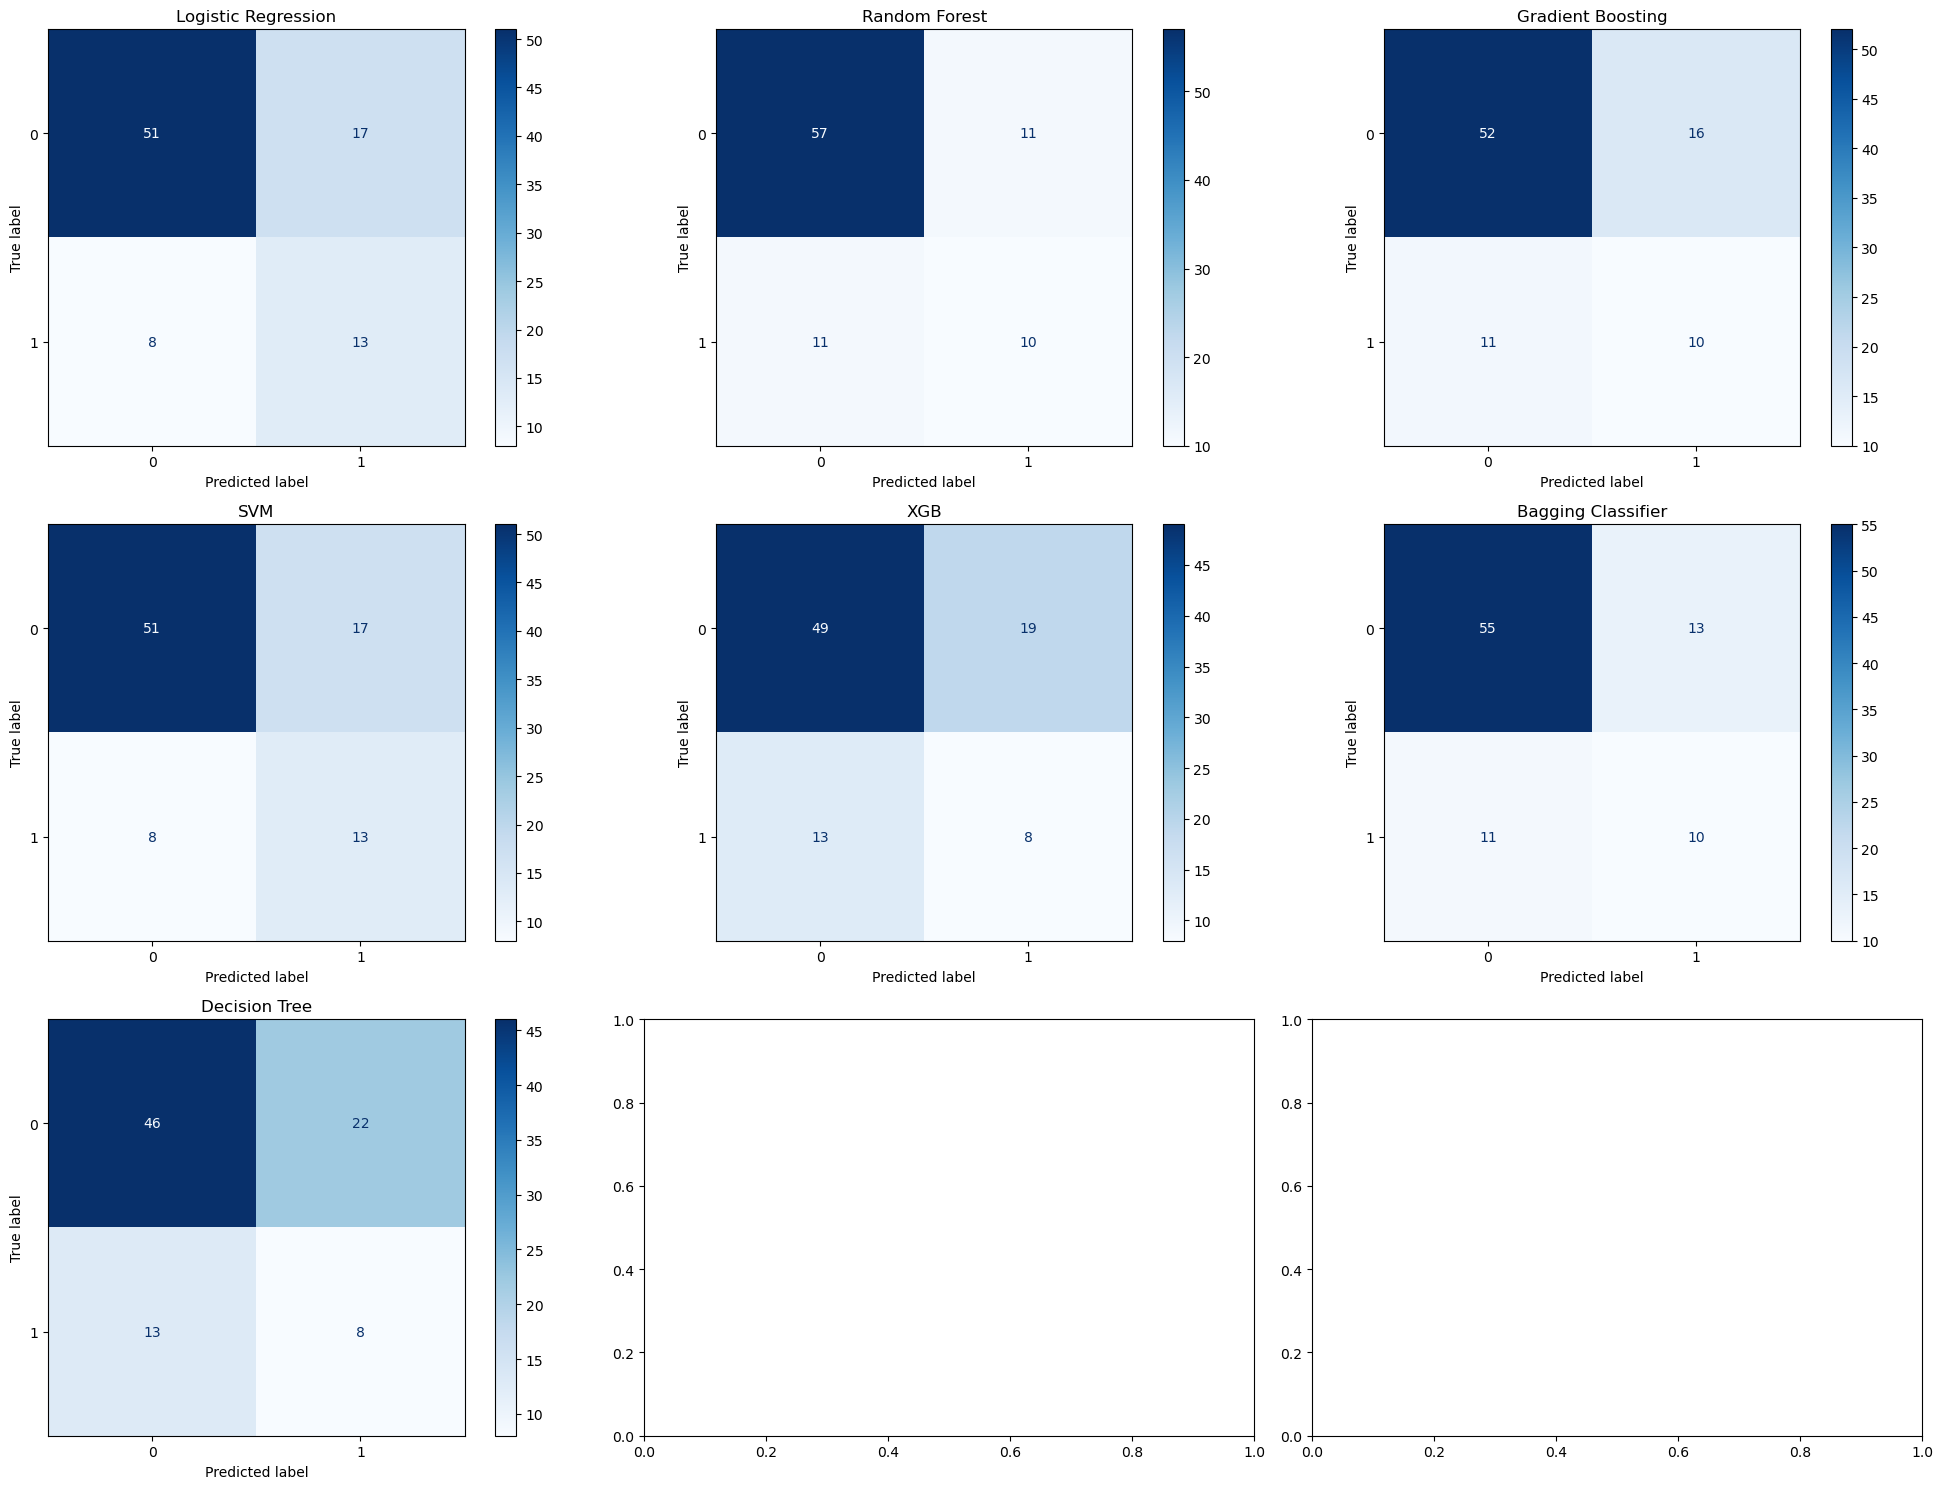

In [34]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print(f"Original class distribution: {Counter(y_train)}")
print(f"SMOTE class distribution: {Counter(y_train_smote)}")

# Initialize all models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, objective='binary:logistic'),
    'Bagging Classifier': BaggingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Dictionary to hold the results and confusion matrices
results = {}
conf_matrices = {}

# Train, evaluate each model using the SMOTE-balanced data, and store confusion matrices
for name, model in models.items():
    # Train the model on the balanced dataset
    model.fit(X_train_smote, y_train_smote)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }
    
    # Store confusion matrix
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T

# Display results
print(results_df)

# Visualization of Confusion Matrices
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
for ax, (name, matrix) in zip(axes.flatten(), conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.title.set_text(name)
plt.tight_layout()
plt.show()


# Simple Data Models check

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.730337   0.748483  0.730337  0.737976
Random Forest        0.831461   0.838448  0.831461  0.801037
Gradient Boosting    0.707865   0.727107  0.707865  0.716140
SVM                  0.707865   0.736942  0.707865  0.719382
xgb                  0.584270   0.637802  0.584270  0.606221
Bagging Classifier   0.707865   0.717458  0.707865  0.712324
Decision Tree        0.617978   0.708332  0.617978  0.645202


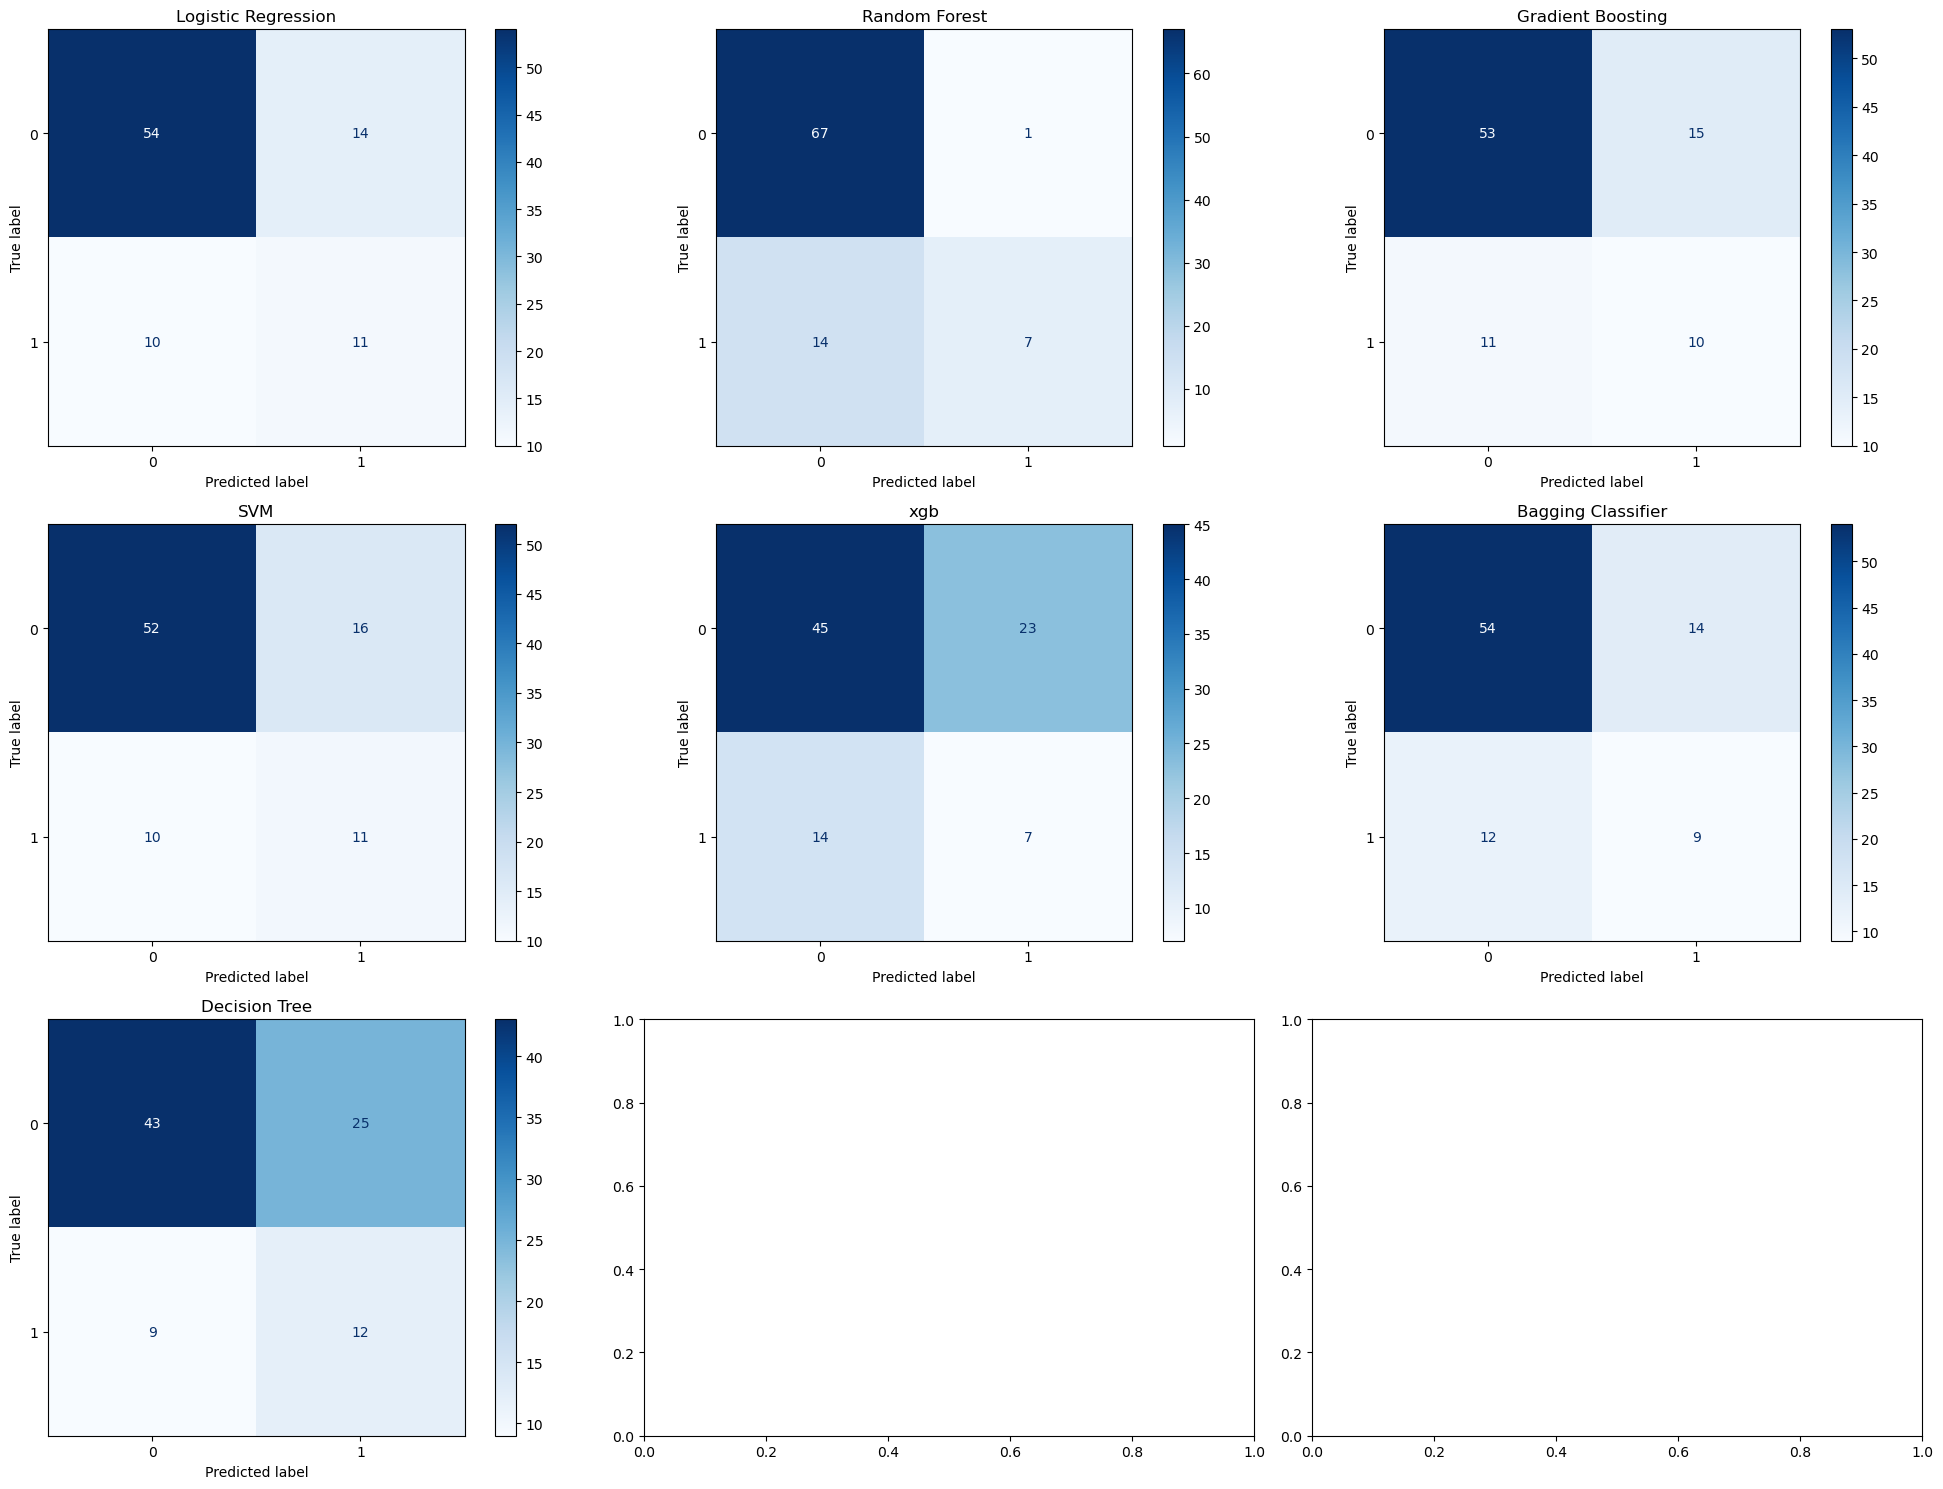

In [8]:
# Initialize all models
models = {
    'Logistic Regression': LogisticRegression(max_iter=50000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'xgb': XGBClassifier( use_label_encoder=False, eval_metric='mlogloss', random_state=42, objective='binary:logistic'),
    'Bagging Classifier': BaggingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Dictionary to hold the results and confusion matrices
results = {}
conf_matrices = {}

# Train, evaluate each model, and store confusion matrices
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }
    
    # Store confusion matrix
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T

# Display results
print(results_df)

# Visualization of Confusion Matrices
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
for ax, (name, matrix) in zip(axes.flatten(), conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.title.set_text(name)
plt.tight_layout()
plt.show()


# Optimized SVM

Accuracy: 0.6741573033707865
Precision: 0.6687347337567171
Recall: 0.6741573033707865
F1 Score: 0.6713728188704835


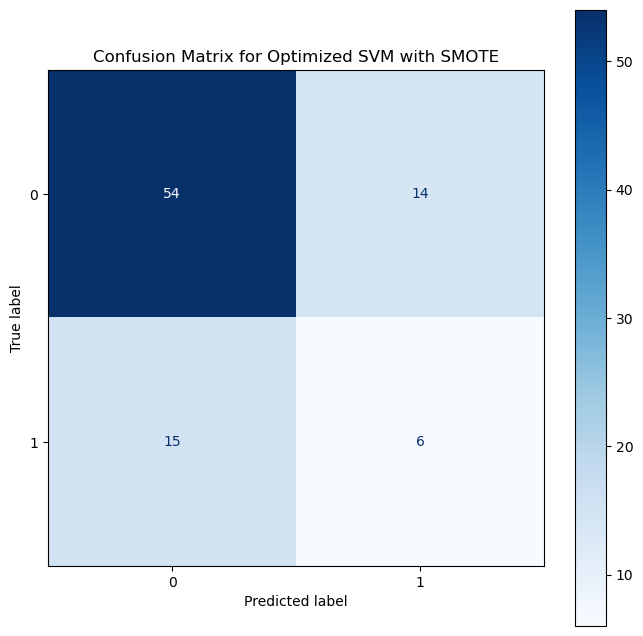

In [ ]:
# Initialize the optimized SVM with the best parameters found by GridSearchCV
optimized_svm = SVC(
    random_state=42
)

# Fit the SVM model on the SMOTE-enhanced training data
optimized_svm.fit(X_train_smote, y_train_smote)

# Make predictions on the original (unbalanced) test set
y_pred_svm = optimized_svm.predict(X_test)

# Calculate evaluation metrics
optimized_accuracy_svm = accuracy_score(y_test, y_pred_svm)
optimized_precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
optimized_recall_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=0)
optimized_f1_svm = f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)

# Calculate and display the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(f"Accuracy: {optimized_accuracy_svm}")
print(f"Precision: {optimized_precision_svm}")
print(f"Recall: {optimized_recall_svm}")
print(f"F1 Score: {optimized_f1_svm}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as necessary
disp_svm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm)
disp_svm.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized SVM with SMOTE')
plt.show()


Accuracy: 0.7528089887640449
Precision: 0.5817160367722165
Recall: 0.7528089887640449
F1 Score: 0.6562950158455778


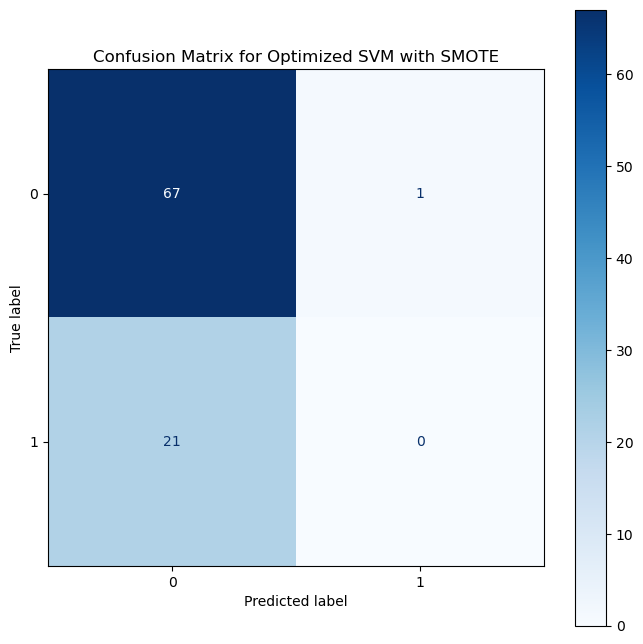

In [ ]:
# Initialize the optimized SVM with the best parameters found by GridSearchCV
optimized_svm = SVC(
    random_state=42
)

# Fit the SVM model on the SMOTE-enhanced training data
optimized_svm.fit(X_train, y_train)

# Make predictions on the original (unbalanced) test set
y_pred_svm = optimized_svm.predict(X_test)

# Calculate evaluation metrics
optimized_accuracy_svm = accuracy_score(y_test, y_pred_svm)
optimized_precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
optimized_recall_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=0)
optimized_f1_svm = f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)

# Calculate and display the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(f"Accuracy: {optimized_accuracy_svm}")
print(f"Precision: {optimized_precision_svm}")
print(f"Recall: {optimized_recall_svm}")
print(f"F1 Score: {optimized_f1_svm}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as necessary
disp_svm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm)
disp_svm.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized SVM with SMOTE')
plt.show()


# Parametrs for Grad Boosting

# Optimized Grad Boost

Accuracy: 0.7865168539325843
Precision: 0.7978176318063959
Recall: 0.7865168539325843
F1 Score: 0.7912252541466025


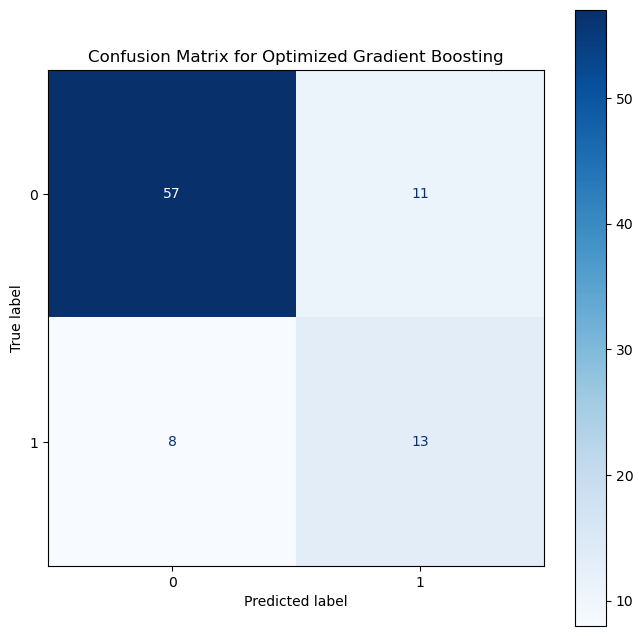

In [ ]:
# initialized Gradient Boosting model with the best parameters
optimized_gb = GradientBoostingClassifier(
    learning_rate=0.3,
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=4,
    n_estimators=300,
    subsample=0.7,
    random_state=42
)

# Fit the model to the training data
optimized_gb.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_gb = optimized_gb.predict(X_test)

# Calculate metrics
optimized_accuracy_gb = accuracy_score(y_test, y_pred_gb)
optimized_precision_gb = precision_score(y_test, y_pred_gb, average='weighted')
optimized_recall_gb = recall_score(y_test, y_pred_gb, average='weighted')
optimized_f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

print(f"Accuracy: {optimized_accuracy_gb}")
print(f"Precision: {optimized_precision_gb}")
print(f"Recall: {optimized_recall_gb}")
print(f"F1 Score: {optimized_f1_gb}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_gb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gb)
disp_gb.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized Gradient Boosting')
plt.show()


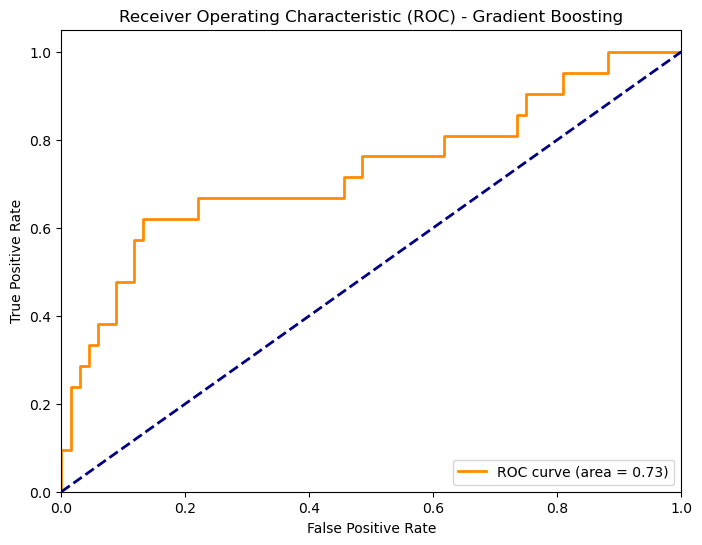

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Step 1: Compute probabilities
y_scores_gb = optimized_gb.predict_proba(X_test)[:, 1]  # get the scores for the positive class

# Step 2: Calculate ROC curve and AUC
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
auc_gb = roc_auc_score(y_test, y_scores_gb)

# Step 3: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2,
         label=f'ROC curve (area = {auc_gb:.2f})')  # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for chance level
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()


In [45]:
from sklearn.utils import resample
import numpy as np

# Number of bootstrap samples to create
n_bootstraps = 1000
# List to store the bootstrapped accuracies
bootstrap_accuracies = []

for _ in range(n_bootstraps):
    # Sample with replacement from X_test and y_test
    X_test_resampled, y_test_resampled = resample(X_test, y_test)
    # Make predictions with the optimized model
    y_pred_resampled = optimized_gb.predict(X_test_resampled)
    # Calculate accuracy for this bootstrap sample
    accuracy = accuracy_score(y_test_resampled, y_pred_resampled)
    bootstrap_accuracies.append(accuracy)

# Calculate the 2.5th and 97.5th percentiles to get the 95% confidence interval
confidence_lower = np.percentile(bootstrap_accuracies, 2.5)
confidence_upper = np.percentile(bootstrap_accuracies, 97.5)

confidence_lower, confidence_upper


(0.6966292134831461, 0.8651685393258427)

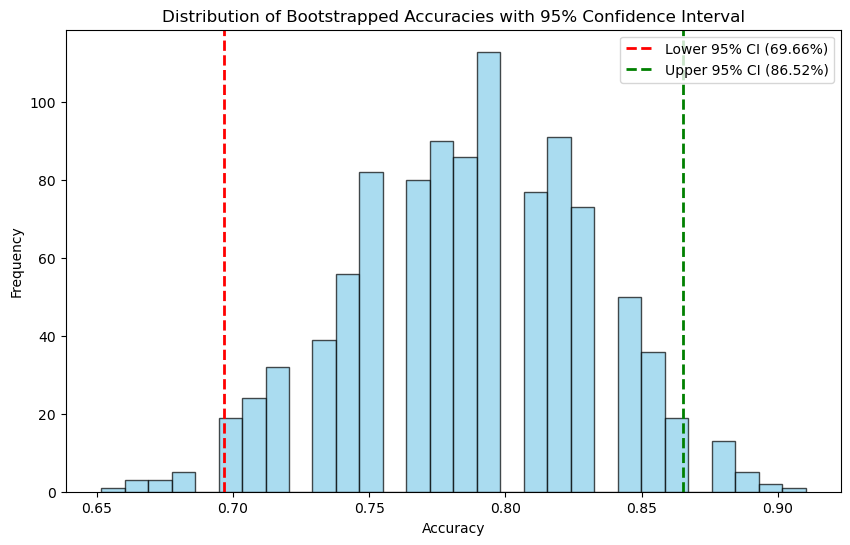

In [46]:
import matplotlib.pyplot as plt

# Plotting the distribution of bootstrapped accuracies
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_accuracies, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(confidence_lower, color='red', linestyle='dashed', linewidth=2, label=f'Lower 95% CI ({confidence_lower:.2%})')
plt.axvline(confidence_upper, color='green', linestyle='dashed', linewidth=2, label=f'Upper 95% CI ({confidence_upper:.2%})')

plt.title('Distribution of Bootstrapped Accuracies with 95% Confidence Interval')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Accuracy: 0.7865168539325843
Precision for each class: [0.87692308 0.54166667]
Recall for each class: [0.83823529 0.61904762]
F1 Score for each class: [0.85714286 0.57777778]


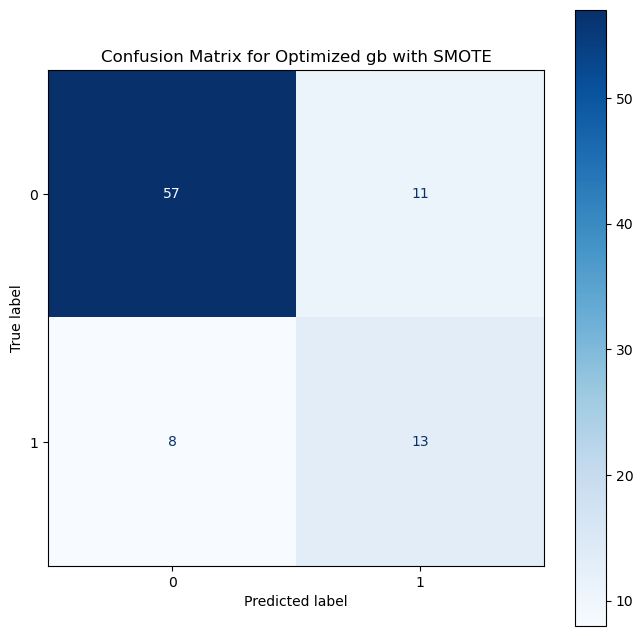

In [47]:

# Calculate evaluation metrics for each class
optimized_accuracy_gb = accuracy_score(y_test, y_pred_gb)
optimized_precision_gb = precision_score(y_test, y_pred_gb, average=None, zero_division=0)  # Scores for each class
optimized_recall_gb = recall_score(y_test, y_pred_gb, average=None, zero_division=0)  # Scores for each class
optimized_f1_gb = f1_score(y_test, y_pred_gb, average=None, zero_division=0)  # Scores for each class

# Print the metrics for each class
print(f"Accuracy: {optimized_accuracy_gb}")
print("Precision for each class:", optimized_precision_gb)
print("Recall for each class:", optimized_recall_gb)
print("F1 Score for each class:", optimized_f1_gb)

# Calculate and display the confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as necessary
disp_gb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gb)
disp_gb.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized gb with SMOTE')
plt.show()


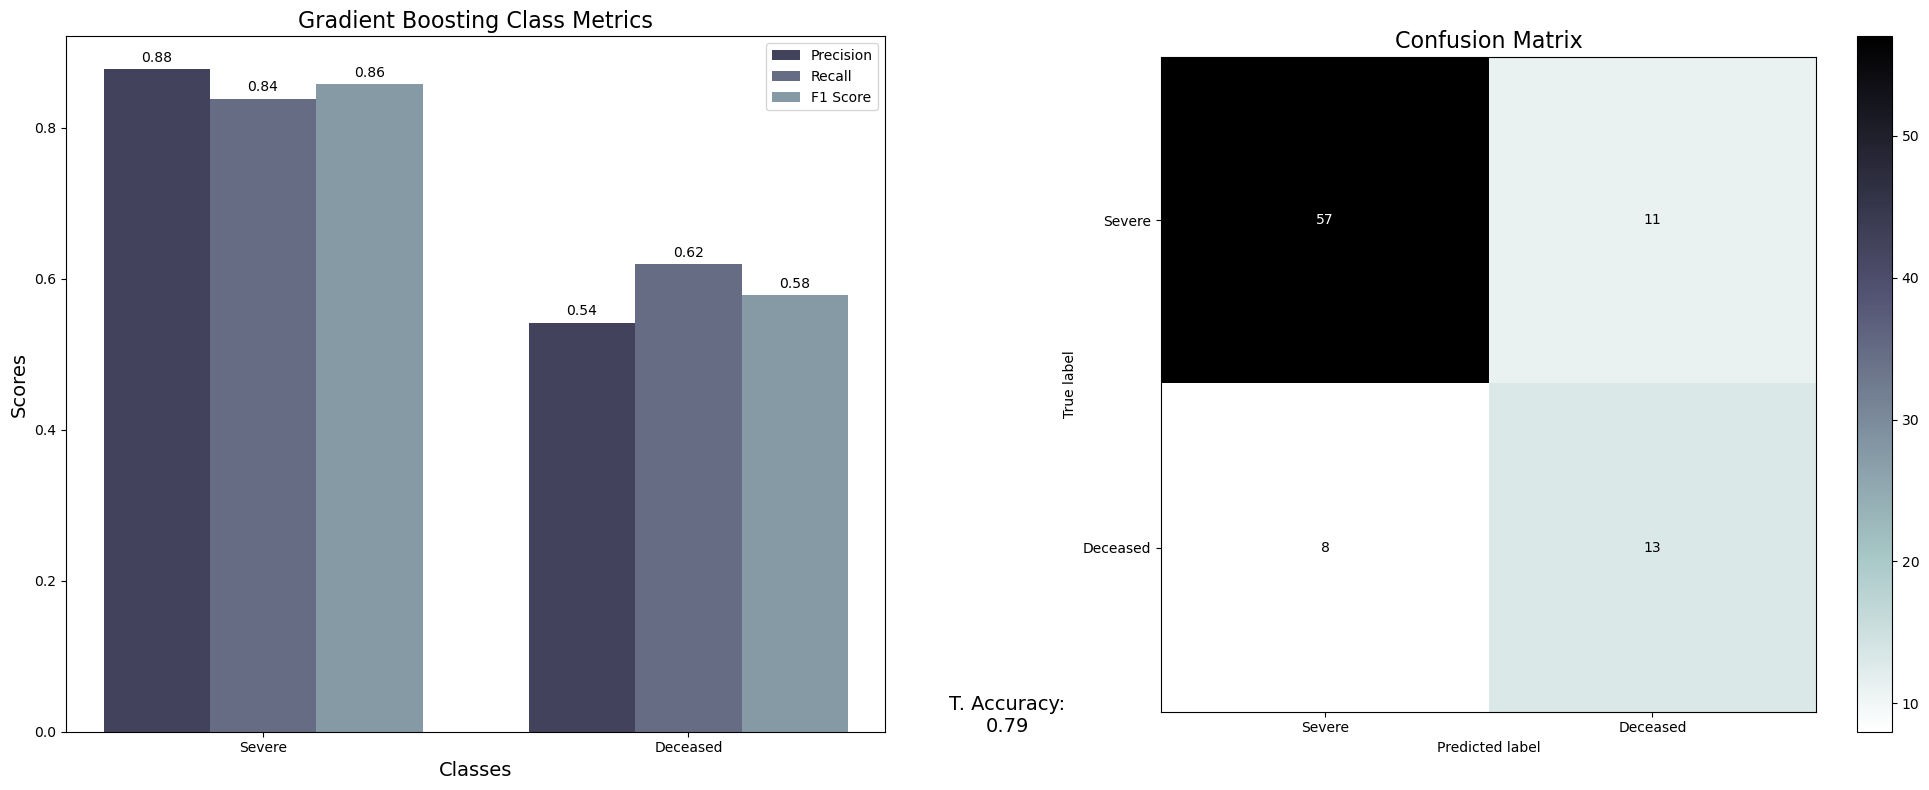

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Setting up the subplot layout
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Two plots side by side
class_labels = ['Severe', 'Deceased']
# Metrics visualization (on the left)
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))  # Generate bone palette for three metrics

# Plotting precision, recall, and F1-score for each class using GB metrics
bar_width = 0.25
index = np.arange(len(class_labels))
axes[0].bar(index, optimized_precision_gb, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, optimized_recall_gb, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, optimized_f1_gb, bar_width, color=bone_palette[2], label='F1 Score')

# Adding details to the GB metrics plot
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('Gradient Boosting Class Metrics', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Annotate the bars with the actual values and add overall accuracy for GB
for i in index:
    axes[0].text(i, optimized_precision_gb[i] + 0.01, f'{optimized_precision_gb[i]:.2f}', ha='center')
    axes[0].text(i + bar_width, optimized_recall_gb[i] + 0.01, f'{optimized_recall_gb[i]:.2f}', ha='center')
    axes[0].text(i + 2 * bar_width, optimized_f1_gb[i] + 0.01, f'{optimized_f1_gb[i]:.2f}', ha='center')

# Adding the overall accuracy for GB
axes[0].text(len(class_labels), 0, f'T. Accuracy:\n{optimized_accuracy_gb:.2f}', fontsize=14, ha='center')

# Confusion matrix visualization (on the right) for GB
conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix_gb, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Confusion Matrix', fontsize=16)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Calculate the probability scores of the positive class
y_scores = best_gb.predict_proba(X_test_step2_scaled)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_step2, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot ROC
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax[0])
ax[0].plot([0, 1], [0, 1], 'k--', lw=2)  # Dashed diagonal
ax[0].set_title('Receiver Operating Characteristic (ROC)')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_step2, y_pred_step2)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, '2-as-1'])
disp.plot(cmap=plt.cm.Blues, ax=ax[1])
ax[1].set_title('Confusion Matrix for Optimized Gradient Boosting')

plt.show()

print(f"Optimized Model - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, AUC-ROC: {roc_auc}")


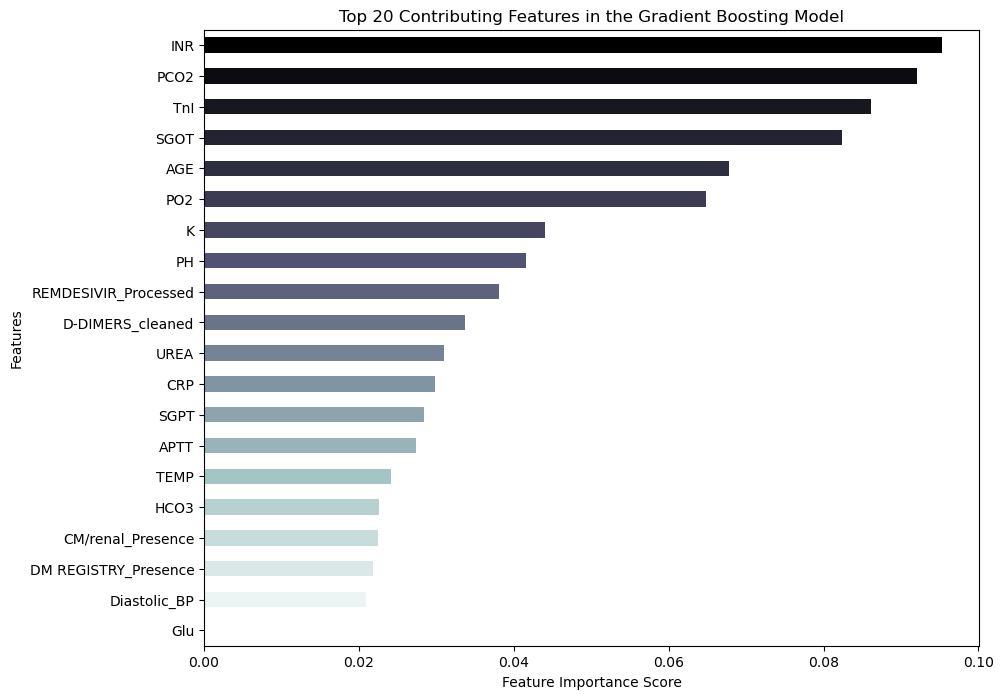

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Access feature importance from the model
feature_importances = optimized_gb.feature_importances_

# Create a pandas series to hold the feature importances and their corresponding feature names
importances = pd.Series(feature_importances, index=X.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# Select the top 20 features
top20_importances = sorted_importances[:20]

# Plotting
plt.figure(figsize=(10, 8))
bone_colors = plt.cm.bone(np.linspace(0, 1, 20))
top20_importances.plot(kind='barh', color=bone_colors)
plt.title('Top 20 Contributing Features in the Gradient Boosting Model')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()



# Parameters for RF

In [ ]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 6, 8, 10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]  
}

# Initialize the GridSearchCV object for Random Forest
rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                       param_grid=param_grid_rf,
                       cv=10,
                       verbose=2,
                       n_jobs=-1,
                       scoring=make_scorer(f1_score, average='weighted'))

# Fit the grid search to the data
rf_grid.fit(X_train_smote, y_train_smote)

# Extract best parameters and best score for Random Forest
best_params_rf = rf_grid.best_params_
best_score_rf = rf_grid.best_score_
print("Best parameters for Random Forest:", best_params_rf)
print("Best weighted F1 score for Random Forest:", best_score_rf)


Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; to

# Optimized RF

Accuracy: 0.7865168539325843
Precision: 0.7767579258321465
Recall: 0.7865168539325843
F1 Score: 0.7806097386567843


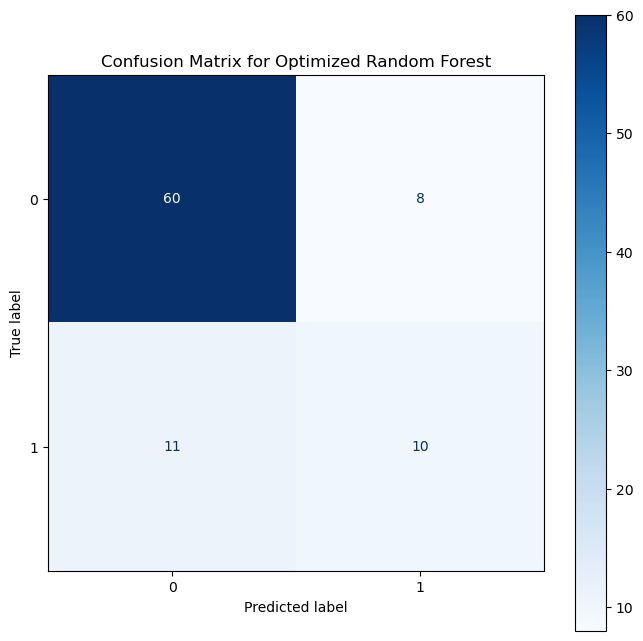

In [ ]:
# Correctly initialized Random Forest model with the best parameters
optimized_rf = RandomForestClassifier(
    n_estimators=100,  
    max_depth=None,    
    min_samples_split=5,  
    min_samples_leaf=1,   
    bootstrap=False,       
    random_state=42
)

# Fit the model to the training data
optimized_rf.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_rf = optimized_rf.predict(X_test)

# Calculate metrics
optimized_accuracy_rf = accuracy_score(y_test, y_pred_rf)
optimized_precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
optimized_recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
optimized_f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print(f"Accuracy: {optimized_accuracy_rf}")
print(f"Precision: {optimized_precision_rf}")
print(f"Recall: {optimized_recall_rf}")
print(f"F1 Score: {optimized_f1_rf}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf)
disp_rf.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized Random Forest')
plt.show()

In [36]:
from sklearn.utils import resample
import numpy as np

# Number of bootstrap samples to create
n_bootstraps = 1000
# List to store the bootstrapped accuracies
bootstrap_accuracies = []

for _ in range(n_bootstraps):
    # Sample with replacement from X_test and y_test
    X_test_resampled, y_test_resampled = resample(X_test, y_test)
    # Make predictions with the optimized model
    y_pred_resampled = optimized_rf.predict(X_test_resampled)
    # Calculate accuracy for this bootstrap sample
    accuracy = accuracy_score(y_test_resampled, y_pred_resampled)
    bootstrap_accuracies.append(accuracy)

# Calculate the 2.5th and 97.5th percentiles to get the 95% confidence interval
confidence_lower = np.percentile(bootstrap_accuracies, 2.5)
confidence_upper = np.percentile(bootstrap_accuracies, 97.5)

confidence_lower, confidence_upper


(0.6966292134831461, 0.8651685393258427)

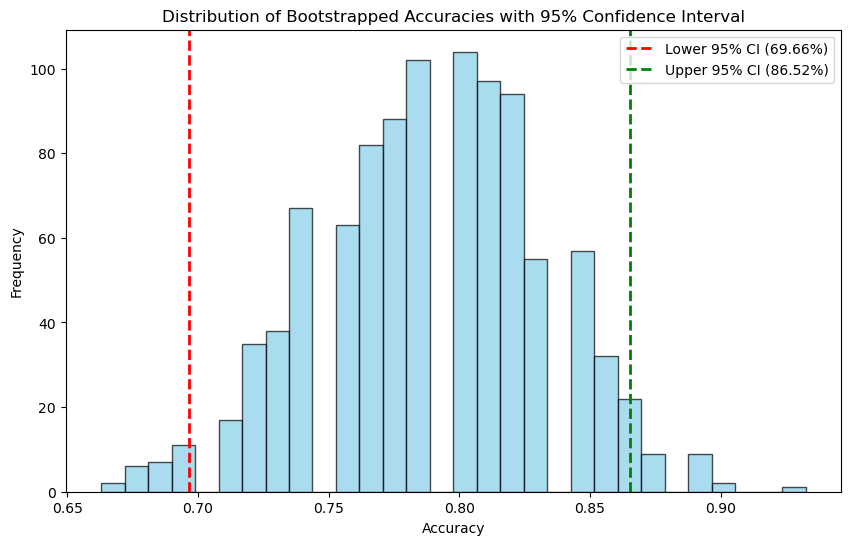

In [ ]:
# Plotting the distribution of bootstrapped accuracies
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_accuracies, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(confidence_lower, color='red', linestyle='dashed', linewidth=2, label=f'Lower 95% CI ({confidence_lower:.2%})')
plt.axvline(confidence_upper, color='green', linestyle='dashed', linewidth=2, label=f'Upper 95% CI ({confidence_upper:.2%})')

plt.title('Distribution of Bootstrapped Accuracies with 95% Confidence Interval')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Accuracy: 0.7865168539325843
Precision for each class: [0.84507042 0.55555556]
Recall for each class: [0.88235294 0.47619048]
F1 Score for each class: [0.86330935 0.51282051]


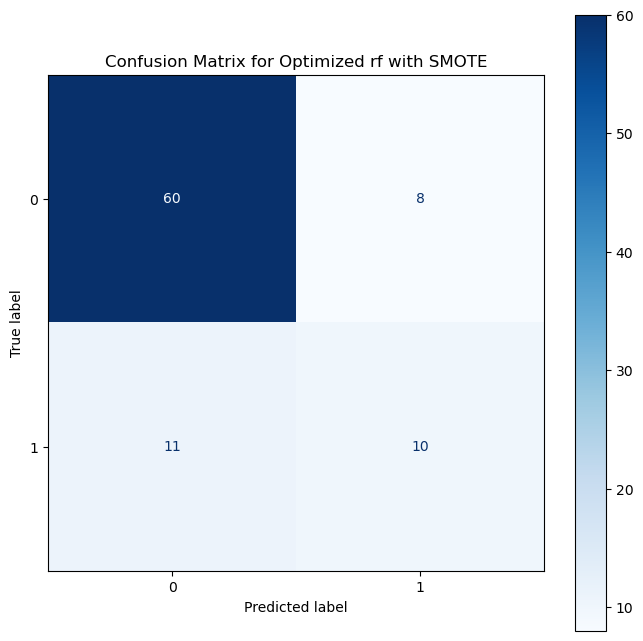

In [37]:

# Calculate evaluation metrics for each class
optimized_accuracy_rf = accuracy_score(y_test, y_pred_rf)
optimized_precision_rf = precision_score(y_test, y_pred_rf, average=None, zero_division=0)  # Scores for each class
optimized_recall_rf = recall_score(y_test, y_pred_rf, average=None, zero_division=0)  # Scores for each class
optimized_f1_rf = f1_score(y_test, y_pred_rf, average=None, zero_division=0)  # Scores for each class

# Print the metrics for each class
print(f"Accuracy: {optimized_accuracy_rf}")
print("Precision for each class:", optimized_precision_rf)
print("Recall for each class:", optimized_recall_rf)
print("F1 Score for each class:", optimized_f1_rf)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as necessary
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf)
disp_rf.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized rf with SMOTE')
plt.show()


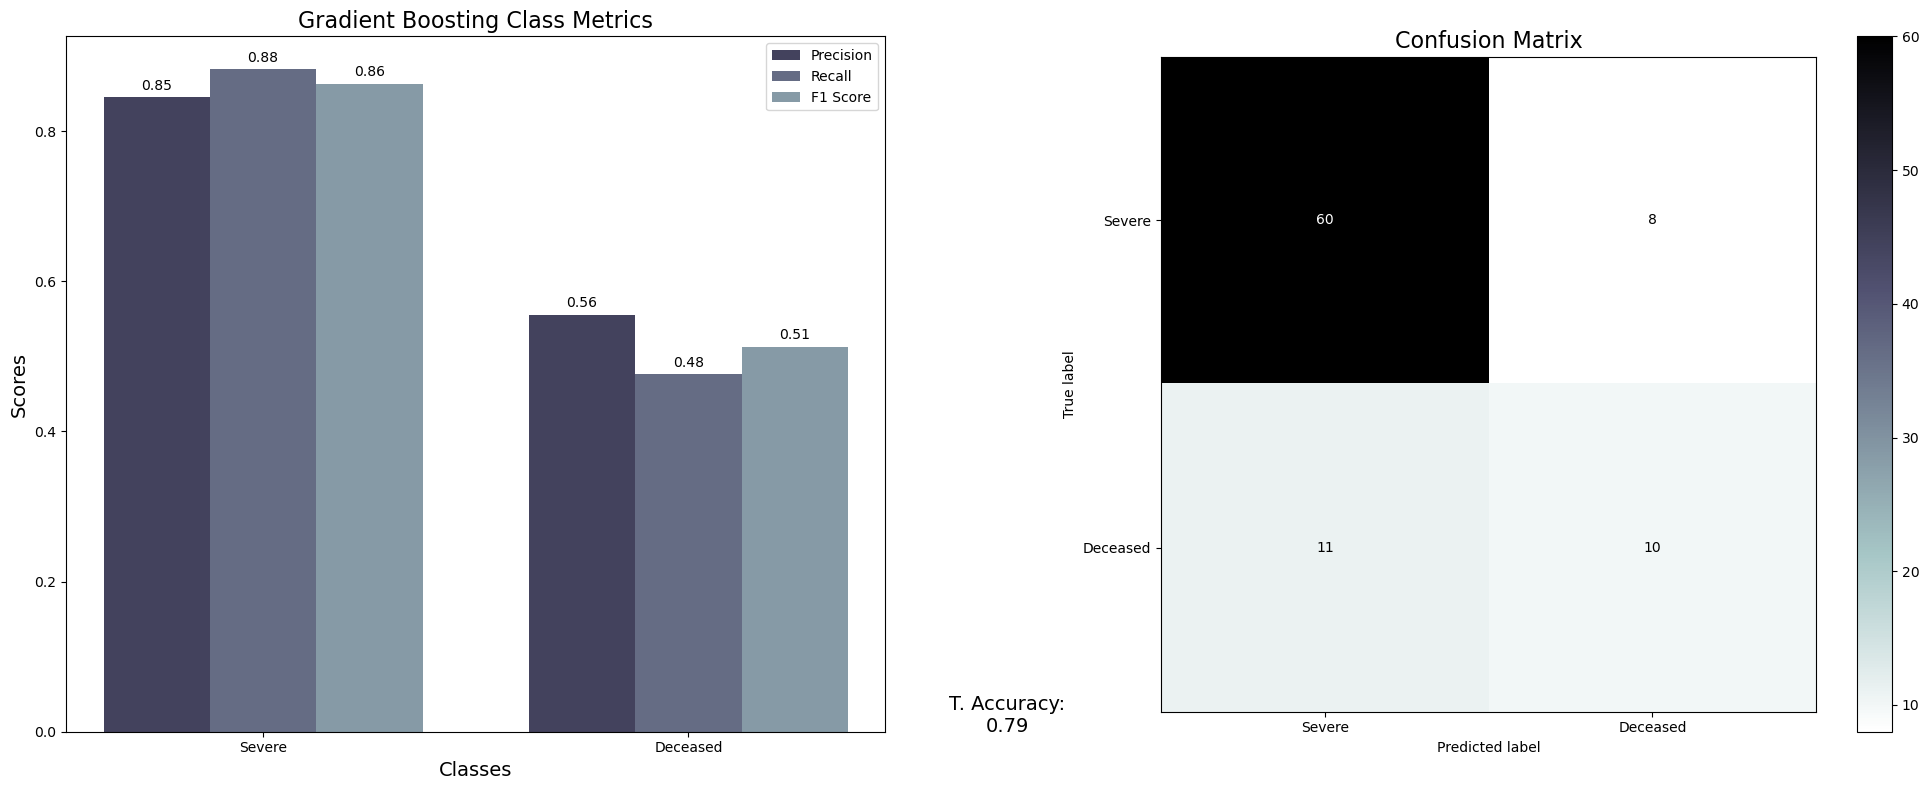

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Setting up the subplot layout
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Two plots side by side
class_labels = ['Severe', 'Deceased']
# Metrics visualization (on the left)
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))  # Generate bone palette for three metrics

# Plotting precision, recall, and F1-score for each class using rf metrics
bar_width = 0.25
index = np.arange(len(class_labels))
axes[0].bar(index, optimized_precision_rf, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, optimized_recall_rf, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, optimized_f1_rf, bar_width, color=bone_palette[2], label='F1 Score')

# Adding details to the rf metrics plot
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('Gradient Boosting Class Metrics', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Annotate the bars with the actual values and add overall accuracy for rf
for i in index:
    axes[0].text(i, optimized_precision_rf[i] + 0.01, f'{optimized_precision_rf[i]:.2f}', ha='center')
    axes[0].text(i + bar_width, optimized_recall_rf[i] + 0.01, f'{optimized_recall_rf[i]:.2f}', ha='center')
    axes[0].text(i + 2 * bar_width, optimized_f1_rf[i] + 0.01, f'{optimized_f1_rf[i]:.2f}', ha='center')

# Adding the overall accuracy for rf
axes[0].text(len(class_labels), 0, f'T. Accuracy:\n{optimized_accuracy_rf:.2f}', fontsize=14, ha='center')

# Confusion matrix visualization (on the right) for rf
conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix_rf, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Confusion Matrix', fontsize=16)

plt.tight_layout()
plt.show()


# Parameters for XGBoost

In [ ]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the GridSearchCV object for XGBoost
xgb_grid = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                        param_grid=param_grid_xgb,
                        cv=10,
                        verbose=2,
                        n_jobs=-1,
                        scoring=make_scorer(f1_score, average='weighted'))

# Fit the grid search to the data
xgb_grid.fit(X_train_smote, y_train_smote)

# Extract best parameters and best score for XGBoost
best_params_xgb = xgb_grid.best_params_
best_score_xgb = xgb_grid.best_score_
print("Best parameters for XGBoost:", best_params_xgb)
print("Best weighted F1 score for XGBoost:", best_score_xgb)


Fitting 10 folds for each of 729 candidates, totalling 7290 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; to

# Optimized XGBoost

Accuracy: 0.7752808988764045
Precision: 0.7829639827685748
Recall: 0.7752808988764045
F1 Score: 0.7787111429573278


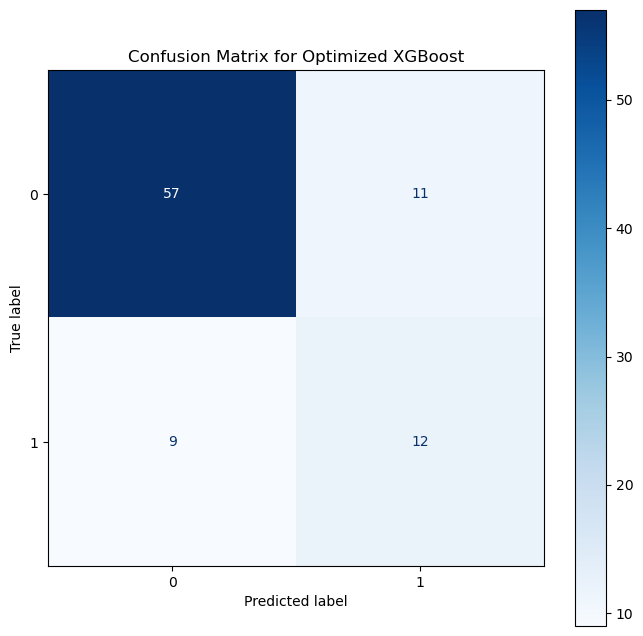

In [ ]:
# Correctly initialized XGBoost model with the best parameters
optimized_xgb = XGBClassifier(
    learning_rate=0.1,    
    n_estimators=200,     
    max_depth=2,          
    min_child_weight=3,   
    subsample=0.4,        
    colsample_bytree=0.6, 
    use_label_encoder=True  
)

# Fit the model to the training data
optimized_xgb.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_xgb = optimized_xgb.predict(X_test)

# Calculate metrics
optimized_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
optimized_precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
optimized_recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
optimized_f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"Accuracy: {optimized_accuracy_xgb}")
print(f"Precision: {optimized_precision_xgb}")
print(f"Recall: {optimized_recall_xgb}")
print(f"F1 Score: {optimized_f1_xgb}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb)
disp_xgb.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized XGBoost')
plt.show()


Accuracy: 0.7640449438202247
Precision: 0.5837646761772503
Recall: 0.7640449438202247
F1 Score: 0.6618478494238889


/Users/michael/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/michael/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


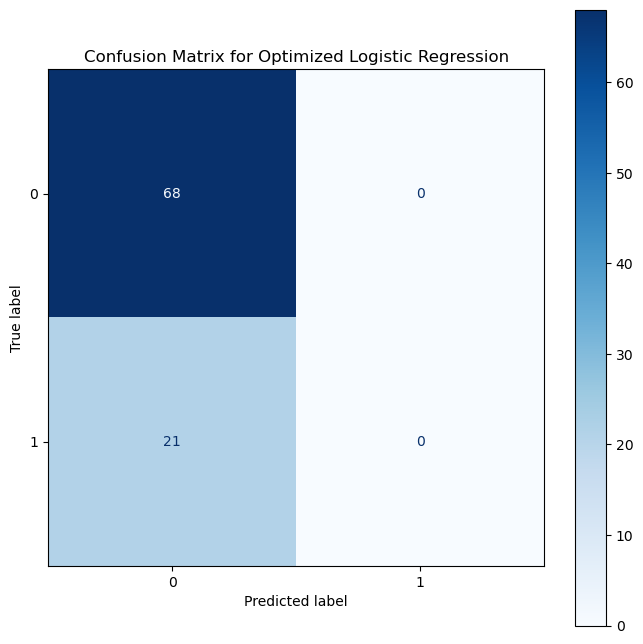

In [ ]:
from sklearn.linear_model import LogisticRegression
# Best parameters for Logistic Regression (replace with your actual best parameters)
best_params_lr = {
    'C': 0.1,  
    'penalty': 'l2',  
    'solver': 'liblinear' 
}

# Correctly initialized Logistic Regression model with the best parameters
optimized_lr = LogisticRegression(
    max_iter=50000,  
    random_state=42
)

# Fit the model to the SMOTE-enhanced training data
optimized_lr.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_lr = optimized_lr.predict(X_test_scaled)  # Make sure to use scaled data

# Calculate metrics
optimized_accuracy_lr = accuracy_score(y_test, y_pred_lr)
optimized_precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
optimized_recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
optimized_f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

print(f"Accuracy: {optimized_accuracy_lr}")
print(f"Precision: {optimized_precision_lr}")
print(f"Recall: {optimized_recall_lr}")
print(f"F1 Score: {optimized_f1_lr}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_lr = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr)
disp_lr.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized Logistic Regression')
plt.show()


In [110]:
# Calculate metrics for each model
metrics = {}
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'XGBoost']  
predictions = [y_pred_lr, y_pred_rf, y_pred_gb,  y_pred_svm, y_pred_xgb]

for model, y_pred in zip(models, predictions):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    metrics[model] = [accuracy, precision, recall, f1]


In [ ]:
# Assuming 'models' and 'accuracies' are defined
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'XGBoost']  
accuracies = [metrics[model][0] for model in models]  # Example accuracy values

# Set up the figure for a horizontal bar chart
plt.figure(figsize=(10, 5))
ax = plt.subplot()

# Define a professional, muted color palette
colors = ['#34495e', '#7f8c8d', '#95a5a6', '#bdc3c7', '#e74c3c']  # Dark and grey shades with a touch of color

# Plot horizontal bars
y_positions = np.arange(len(models))
bars = ax.barh(y_positions, accuracies, color=colors, edgecolor='black', linewidth=1, alpha=0.7)

# Highlight the best performer by adjusting its properties
best_idx = np.argmax(accuracies)
bars[best_idx].set_color('#2ecc71') 
bars[best_idx].set_edgecolor('black')

# Add text annotations for accuracy percentages
for bar in bars:
    width = bar.get_width()
    ax.text(width - 0.05, bar.get_y() + bar.get_height() / 2, f'{width:.2%}', 
            ha='right', va='center', color='white', fontweight='bold', fontsize=10)

# Aesthetic improvements for a professional look
ax.set_yticks(y_positions)
ax.set_yticklabels(models, fontsize=12)
ax.invert_yaxis() 
ax.set_xlabel('Accuracy', fontsize=14)
ax.set_xlim(0, max(accuracies) + 0.1)
ax.set_title('Comparison of Model Accuracies', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.5, which='major', axis='x') 
ax.set_facecolor('#ecf0f1')  
ax.tick_params(axis='both', which='both', length=0)  

plt.tight_layout()
plt.show()


NameError: name 'metrics' is not defined

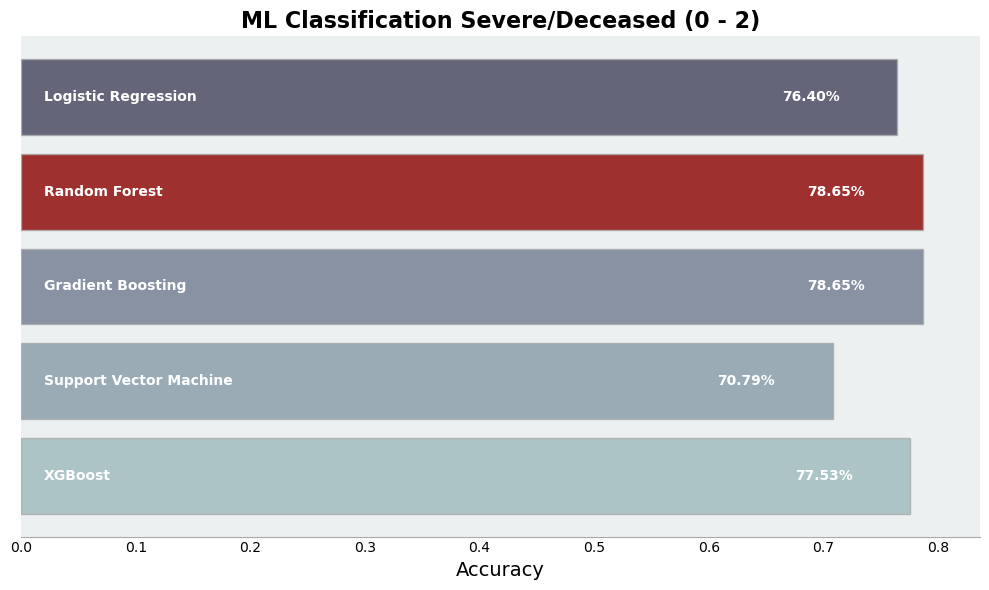

In [113]:
# Assuming 'models' and 'accuracies' are defined
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'XGBoost']  
accuracies = [metrics[model][0] for model in models] 

# Set up the figure for a horizontal bar chart
plt.figure(figsize=(10, 6))
ax = plt.subplot()

# Define a professional, muted color palette using 'bone'
colors = plt.cm.bone(np.linspace(0.3, 0.7, len(models)))

# Plot horizontal bars
y_positions = np.arange(len(models))
bars = ax.barh(y_positions, accuracies, color=colors, edgecolor='darkgrey', linewidth=1, alpha=0.8)

# Highlight the best performer by adjusting its properties
best_idx = np.argmax(accuracies)
bars[best_idx].set_color('#8B0000') 
bars[best_idx].set_edgecolor('darkgrey')

# Add text annotations for accuracy percentages inside the bars
for bar, accuracy in zip(bars, accuracies):
    ax.text(bar.get_width() - 0.05, bar.get_y() + bar.get_height() / 2, f'{accuracy:.2%}', 
            ha='right', va='center', color='white', fontweight='bold', fontsize=10)

# Add text annotations for the full names of each algorithm inside the bars
for bar, model_name in zip(bars, models):
    ax.text(0.02, bar.get_y() + bar.get_height() / 2, model_name, 
            ha='left', va='center', color='white', fontweight='bold', fontsize=10)

# Aesthetic improvements
ax.set_yticks([])  
ax.invert_yaxis()  
ax.set_xlabel('Accuracy', fontsize=14)
ax.set_xlim(0, max(accuracies) + 0.05)  
ax.set_title('ML Classification Severe/Deceased (0 - 2)', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
ax.spines['bottom'].set_color('darkgrey')
ax.set_facecolor('#ecf0f1')  
ax.tick_params(axis='both', which='both', length=0)  

plt.tight_layout()
plt.show()


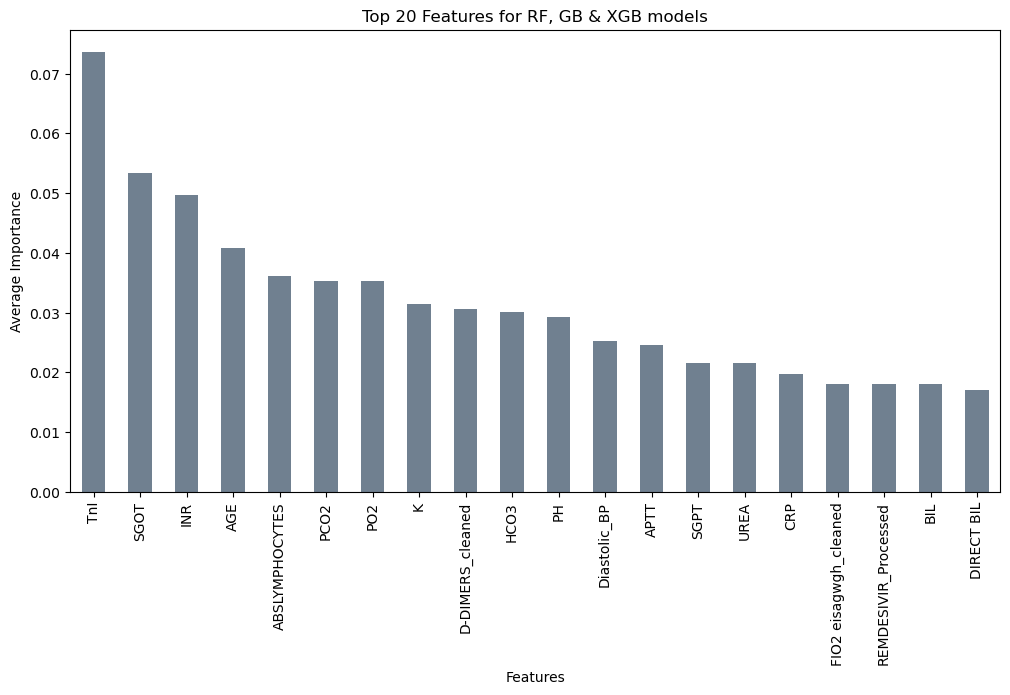

In [24]:
# Assuming X_train has feature names
feature_names = X_train.columns

# Placeholder dictionaries for feature importances from each model
feature_importances = {
    'rf': optimized_rf.feature_importances_,
    'gb': optimized_gb.feature_importances_,
    'xgb': optimized_xgb.feature_importances_
}

# Initialize a DataFrame to hold aggregated feature importances
importance_df = pd.DataFrame(index=feature_names)

# Fill the DataFrame with feature importances from each model
for model_name, importances in feature_importances.items():
    importance_df[model_name] = importances

# Calculate average importance for each feature
importance_df['average'] = importance_df.mean(axis=1)

# Sort features based on average importance
sorted_features = importance_df.sort_values(by='average', ascending=False)

# Visualize the top 20 features 
top_features = sorted_features.head(20)
top_features['average'].plot(kind='bar', figsize=(12, 6), color='slategray')
plt.title('Top 20 Features for RF, GB & XGB models')
plt.ylabel('Average Importance')
plt.xlabel('Features')
plt.show()


In [49]:
import shap
shap.initjs()
# Initialize SHAP explainers
explainers = {
    'Random Forest': shap.TreeExplainer(optimized_rf),
    'Gradient Boosting': shap.TreeExplainer(optimized_gb)
}

shap_values = {
    name: explainer.shap_values(X_test)
    for name, explainer in explainers.items()
}


Model: Random Forest


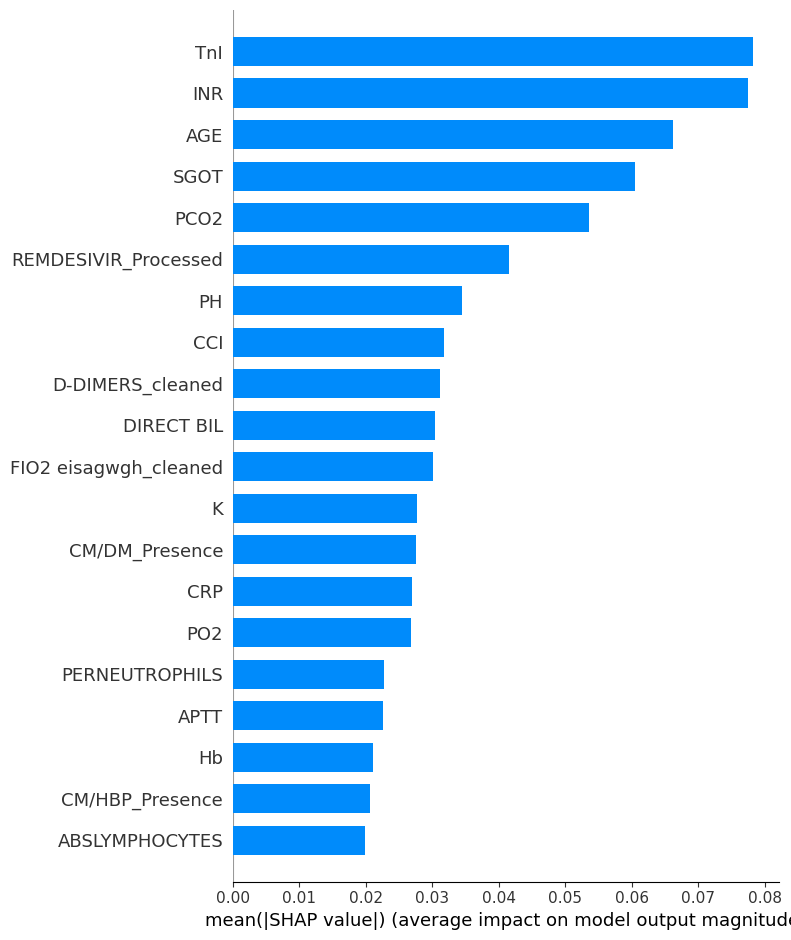

Model: XGBoost


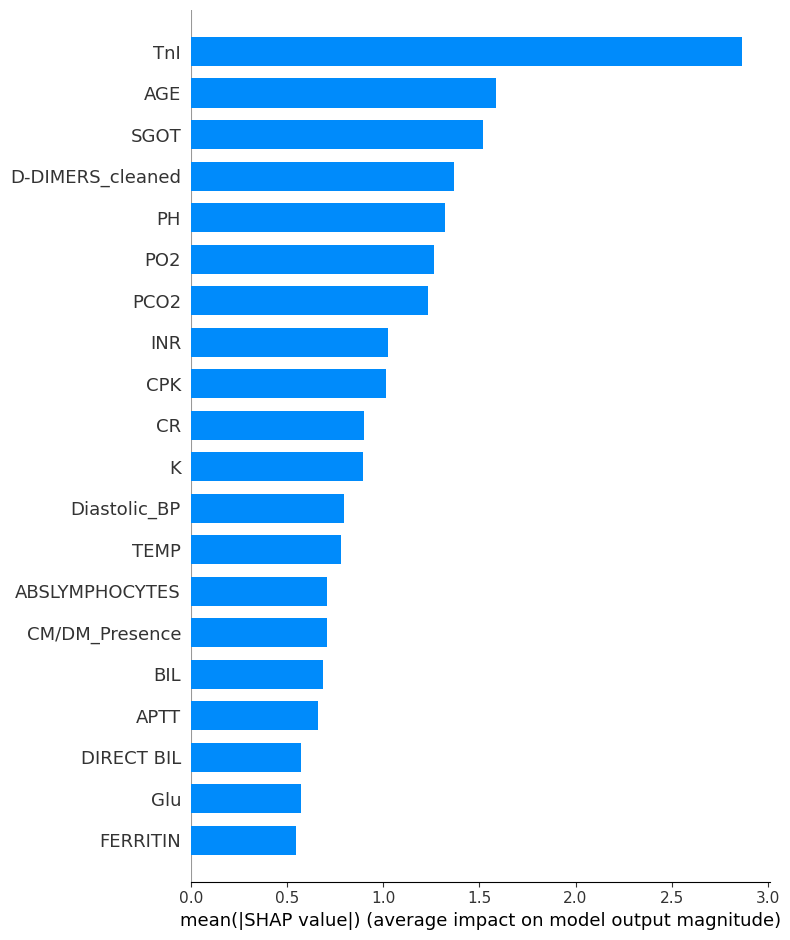

In [ ]:
# Visualization
for model_name, model_shap_values in shap_values.items():
    print(f"Model: {model_name}")
    # Check if SHAP values are in multi-class format (list of arrays)
    if isinstance(model_shap_values, list):  # Handling multi-class scenarios
        # Aggregate SHAP values across all classes for each sample
        values_aggregated = np.sum(np.abs(model_shap_values), axis=0)  # Sum across classes, maintaining the sample-feature structure
    else:
        # Use directly if already in the correct format
        values_aggregated = model_shap_values
    
    # Ensure a 2D array for the summary plot
    if len(values_aggregated.shape) == 1:
        # This means SHAP values are somehow still a vector; try reshaping or debugging how they were aggregated
        continue  # Or handle the error appropriately
    
    # Now plotting with the aggregated (summed across classes) SHAP values
    shap.summary_plot(values_aggregated, X_test, plot_type="bar", feature_names=X_test.columns, max_display=20)


Model: Random Forest


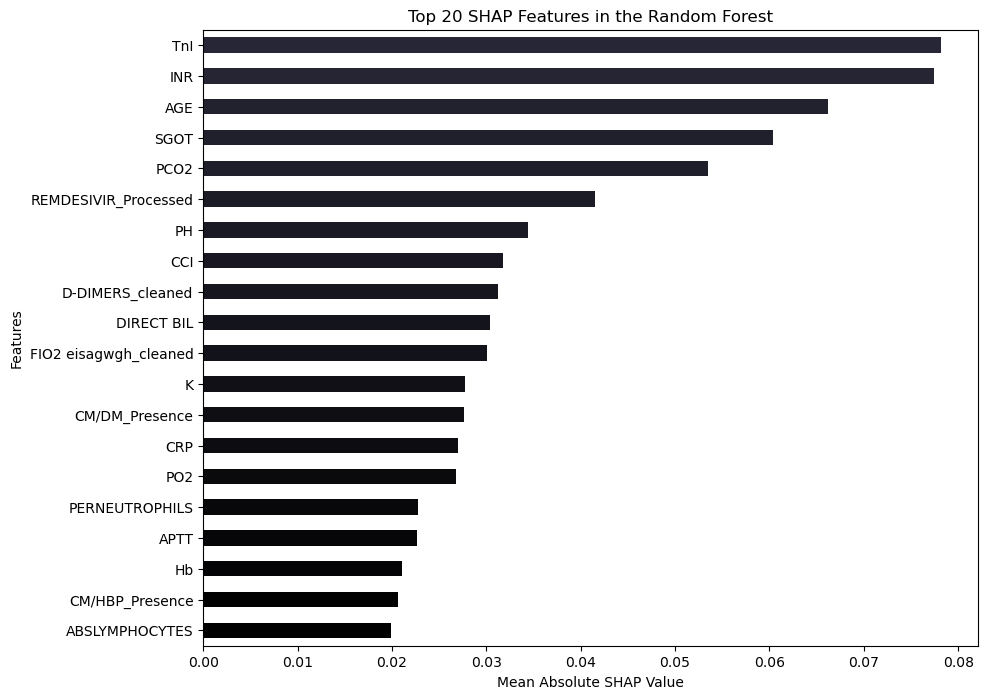

Model: XGBoost


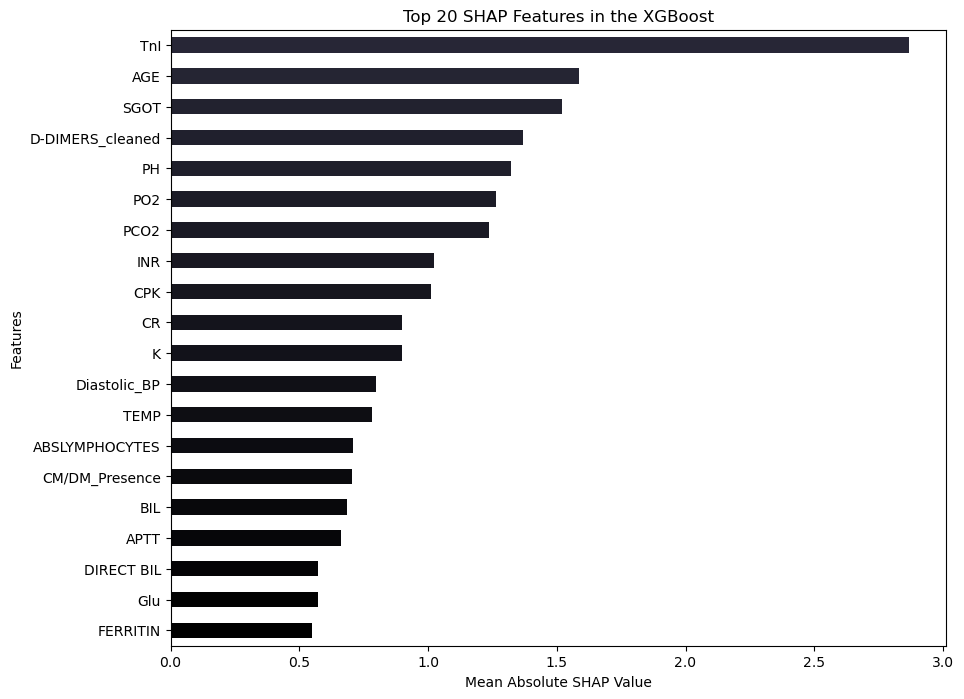

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'X_sample' contains the feature data corresponding to 'shap_values'
for model_name, model_shap_values in shap_values.items():
    print(f"Model: {model_name}")
    if isinstance(model_shap_values, list):
        # Aggregate SHAP values across all classes for each sample
        values_aggregated = np.abs(np.array(model_shap_values)).sum(axis=0).mean(axis=0)
    else:
        # Use directly if already in the correct format (mean absolute values)
        values_aggregated = np.abs(model_shap_values).mean(axis=0)

    # Create a Series for easy plotting, ensuring feature names align
    importances = pd.Series(values_aggregated, index=X_test.columns).sort_values(ascending=True)

    # Plotting in a similar style to your example
    plt.figure(figsize=(10, 8))
    bone_colors = plt.cm.bone(np.linspace(0, 1, len(importances)))
    importances.tail(20).plot(kind='barh', color=bone_colors) 
    plt.title(f'Top 20 SHAP Features in the {model_name}')
    plt.xlabel('Mean Absolute SHAP Value')
    plt.ylabel('Features')
    plt.gca()  
    plt.show()
